In [1]:
# 모듈 import
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets


In [2]:
# 딥러닝 모델을 설계할 때 활용하는 장비 확인하기
if torch.cuda.is_available() :
    DEVICE = torch.device('cuda')
else :
    DEVICE = torch.device('cpu')
print(f"Using PyTorch version : {torch.__version__}, Device : {DEVICE}")

BATCH_SIZE = 32 # mini_batch size를 의미
EPOCHS = 10

Using PyTorch version : 1.8.1, Device : cpu


In [3]:
# MNIST 데이터 다운로드 (train, test set 분리)


train_dataset = datasets.MNIST(root="../data/MNIST",
                               train = True,
                               download=True,
                               transform=transforms.ToTensor())
test_dataset = datasets.MNIST(root="../data/MNIST",
                               train = False,
                               transform=transforms.ToTensor())
# train == 학습용 데이터인지, 아닌지 설정
# transform.ToTensor() == MNIST는 이미지 데이터 -> MLP의 input으로 사용하기 위해 tensro 형태로 변경하고
#               한 픽셀의 값(0~255)을 0~1 범위에서 정규화 시켜줌


train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)
# 데이터셋을 mini batch 단위로 분리
# shuffle = True, 데이터의 순서를 섞어 label 정보의 순서를 암기해 학습 하는 것을 방지
# 즉 특정 label에 매치된 이미지 데이터의 특징을 보고 학습하는 것이 아니라 특정 이미지 데이터에 매칭된 label 값만을 집중적으로 학습하는
# 잘못된 방향으로 학습하는 것을 방지하기 위해 데이터 순서를 섞는다.


In [4]:
# 데이터 확인하기 (1)
for (X_train, y_train) in train_loader :
    print(f"X_train : {X_train.size()}, type : {X_train.type()}")
    print(f"y_train : {y_train.size()}, type : {y_train.type()}")
    break

# (batch_size, channel, width, height)

X_train : torch.Size([32, 1, 28, 28]), type : torch.FloatTensor
y_train : torch.Size([32]), type : torch.LongTensor


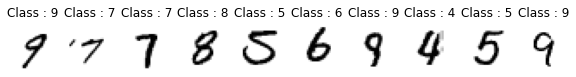

In [5]:
# 데이터 확인하기 (2)
pltsize = 1
plt.figure(figsize=(10*pltsize, pltsize))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(X_train[i,:,:,:].numpy().reshape(28,28), cmap="gray_r")
    plt.title(f'Class : {str(y_train[i].item())}')

In [6]:
# MLP 모델 설계하기
class Net(nn.Module) :
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 512) # (input의 차원수, layer의 node 수)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        self.dropout_prob = 0.5
    def forward(self,x):
        x = x.view(-1, 28*28) # 2차원 이미지 데이터를 1차원으로 펼친다 -> flatten
        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x, training = self.training, p = self.dropout_prob)
        x = self.fc2(x)
        x = F.relu(x)
        x = F.dropout(x, training = self.training, p = self.dropout_prob)
        x = self.fc3(x)
        x = F.log_softmax(x, dim = 1) # 그냥 softmax가 아닌 log_softmax를 사용하는 이유는 gradient 원활하게 계산하려고
        return x

In [7]:
# Optimizer, Objective Function 설정하기
model = Net().to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum=0.5)
criterion = nn.CrossEntropyLoss()
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


In [8]:
# MLP 모델 학습을 진행하면서 학습 데이터에 대한 모델 성능을 확인하는 함수 정의
def train(model, train_loader, optimizer, log_interval, epoch) :
    model.train() # 모델을 학습상태로 만듦
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE) # 데이터를 기존에 정의한 장비에 할당한다.
        label = label.to(DEVICE) # label을 기존에 정의한 장비에 할당한다.
        optimizer.zero_grad() # 기존에 정의한 장비에 데이터를 할당할 경우, 과거에 사용한 데이터를 바탕으로 계산된 loss의 gradient 값이 optimizer에 할당돼 있으므로 optimizer 초기화
        output = model(image)
        loss = criterion(output, label)
        loss.backward() # loss 값을 바탕으로 BP 해서 나온 gradient를 각 파라미터에 할당
        optimizer.step() # 각 파라미터에 할당된 gradient 값을 이용해 파라미터 값 업데이트

        if batch_idx % log_interval == 0 :
            print(f"Train Epoch : {epoch} [{batch_idx*len(image)}/"
                  f"{len(train_loader.dataset)}({100.*batch_idx/len(train_loader):.0f}%)]"
                  f"\tTrain Loss : {loss.item()}")

In [9]:
# 학습되는 과정 속에서 검증 데이터에 대한 모델의 성능을 확인하는 함수 정의
def evaluate(model, test_loader):
    model.eval() # 모델을 평가 상태로 지정
    test_loss = 0 # loss 값
    correct = 0 # 모델이 올바른 class로 분류한 경우를 count

    with torch.no_grad() : # gradient를 통해 parameter가 업데이트 하는 것을 방지하기 위해
        for image, label in test_loader :
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1] # 모델의 ouput은 크기가 10인 벡터이다. 따라서 가장 큰 값이 들어있는 위치를 찾아야 한다.
            correct += prediction.eq(label.view_as(prediction)).sum().item()

            # tensor.max ( return (max, max_index) )
            # view_as == 인자로 들어온 tensor로 모양 변경 (메모리에 tensor를 직접 변경 하는게 아님)
            # eq == tensor를 비교해 같은 위치에 같은 값이 있으면 해당 위치는 True, 아니면 False인 tensor 반환
            # item == tensor를 python single value로 변환 (tensor의 차원은 상관 없으나 값이 1개만 있어야 한다.)

        test_loss /= len(test_loader.dataset)
        test_accuracy = 100. * correct / len(test_loader.dataset)
        return test_loss, test_accuracy

In [10]:
# MLP 학습을 실행하면서 Train, Test set의 Loss 및 Test set accuracy 확인하기
for Epoch in range(1, EPOCHS+1):
    train(model, train_loader, optimizer, log_interval=200, epoch = Epoch)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print(f"\n[EPOCH:{Epoch}] \tTest Loss : {test_loss:.4f}, \tTest Accuracy : {test_accuracy:.2f}\n")

Train Epoch : 1 [0/60000(0%)]	Train Loss : 2.307720184326172
Train Epoch : 1 [6400/60000(11%)]	Train Loss : 2.078394889831543
Train Epoch : 1 [12800/60000(21%)]	Train Loss : 1.2947050333023071
Train Epoch : 1 [19200/60000(32%)]	Train Loss : 0.7696388959884644
Train Epoch : 1 [25600/60000(43%)]	Train Loss : 0.560024082660675
Train Epoch : 1 [32000/60000(53%)]	Train Loss : 0.963682234287262
Train Epoch : 1 [38400/60000(64%)]	Train Loss : 0.46573981642723083
Train Epoch : 1 [44800/60000(75%)]	Train Loss : 0.3503100872039795
Train Epoch : 1 [51200/60000(85%)]	Train Loss : 0.3778499960899353
Train Epoch : 1 [57600/60000(96%)]	Train Loss : 0.34746792912483215

[EPOCH:1] 	Test Loss : 0.0099, 	Test Accuracy : 90.97

Train Epoch : 2 [0/60000(0%)]	Train Loss : 0.5606313347816467
Train Epoch : 2 [6400/60000(11%)]	Train Loss : 0.47299110889434814
Train Epoch : 2 [12800/60000(21%)]	Train Loss : 0.3265518546104431
Train Epoch : 2 [19200/60000(32%)]	Train Loss : 0.2965114712715149
Train Epoch : 2 [25